In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)

import numpy as np

import matplotlib.pyplot as plt

from fomlads.data.external import import_for_classification

from fomlads.model.classification import project_data
from fomlads.model.classification import maximum_separation_projection

from fomlads.plot.exploratory import plot_scatter_array_classes
from fomlads.plot.exploratory import plot_class_histograms
from fomlads.model.classification import fisher_linear_discriminant_projection


from helper_functions import *

# Functions for model fitting and cross validation

In [2]:


# I wrote the get_fisher_histogram function to avoid repeated code
# fisher_linear_discriminant_projection, project_data, and plot_class_histograms are all from fomlads
def get_fisher_histogram(inputs, targets):
    """
    Returns the projected histogram using Fishers model
    """    
    w = fisher_linear_discriminant_projection(inputs, targets)
    projected_inputs = project_data(inputs, w)
    ax = plot_class_histograms(projected_inputs, targets)

   
    
def get_fishers_predictions(inputs, weights, threshold = 0): 
    
    """
    Predicts the targets based on inputs and weights.
    The weights are caluculated using Fishers criterion.
    """
        
    m = np.mean(inputs, axis = 0)
    predictions = []
    
    for x in inputs:
        y = np.matmul(weights.T, x-m) # y = w.T * (x - m)        
        if y > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions
       
        
def cross_validate_fishers(df, num_folds = 10):
    """
    Performs K fold cross validation using fishers model.
    Returns an array containing scores from each iteration.
    
    """
    
    # Gets the row numbers for the training folds and the validaition folds for each iteration.
    # tf_indices -> indices for training folds for each iteration
    # vf_indices -> indices for validation folds for each iteration
    tf_indices, vf_indices = get_fold_indices(df, num_folds)

    # Keeps track of the scores for each iteration of cross validation.
    cross_validation_scores = []

    # Performs cross validation
    for i in range(len(tf_indices)):  

        # Training and validation data for the current iteration/
        train_fold_df = df.iloc[tf_indices[i]]
        validation_fold_df = df.iloc[vf_indices[i]]

        # X and y data for training fold
        train_fold_x = train_fold_df.drop("profit_xy", axis = 1).to_numpy()
        train_fold_y = train_fold_df["profit_xy"].to_numpy()

        # X and y data for validation fold
        validation_fold_x = validation_fold_df.drop("profit_xy", axis = 1).to_numpy()
        validation_fold_y = validation_fold_df["profit_xy"].to_numpy()

        # Gets weights from training fold
        fishers_weights = fisher_linear_discriminant_projection(train_fold_x, train_fold_y)

        # Makes predictions using weights calculated from training fold
        fishers_predictions = get_fishers_predictions(validation_fold_x, fishers_weights)

        # Calucaltes accuracy for current iteration and appends to list
        fold_accuracy = get_accuracy(fishers_predictions, validation_fold_y)
        cross_validation_scores.append(fold_accuracy)


    return cross_validation_scores




# Importing data, model fitting and cross validation

In [3]:

df = pd.read_csv("profit_x_y.csv")
df = df.drop("Unnamed: 0", axis =1 )

df = df.drop("title_x", axis = 1)
df = df.drop("title_y", axis = 1)
df = df.drop("profit_x", axis = 1)
df = df.drop("profit_y", axis = 1)

# Had to remove gross income since it can be used with budget to directly get profit,
# and an unreleased movie will not have a known income.
df = df.drop("worlwide_gross_income_x", axis = 1)
df = df.drop("worlwide_gross_income_y", axis = 1)



# df_train will be used for cross validation, and df_test will be used for final testing and careating the ROC curve.
df_train, df_test = get_train_test_split(df,train_size = 0.8)

# Re-calculates the indices because pandas normally keeps the original indices when you take a section of a dataframe
df_train.reset_index(inplace=True, drop=True) 
df_test.reset_index(inplace=True, drop=True) 

cv_scores = cross_validate_fishers(df_train, num_folds = 5)
average_cv_percent = round(100 * sum(cv_scores)/len(cv_scores),2)

print(f"Cross validation scores(%) = {np.around(100 * np.array(cv_scores),2)}")
print(f"Average cross validation score = {average_cv_percent}%")  
    

Cross validation scores(%) = [69.91 71.3  72.02 70.9  71.56]
Average cross validation score = 71.14%


# ROC Curve

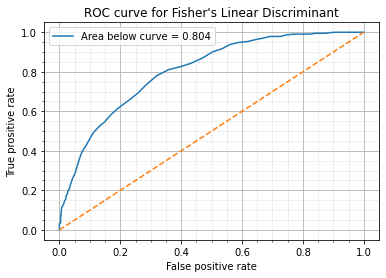

In [4]:
# ROC Curve
tpr = []
fpr = []
    
weights = fisher_linear_discriminant_projection(df_train.drop("profit_xy", axis = 1).to_numpy(), df_train["profit_xy"].to_numpy())
y_true = df_test["profit_xy"].to_numpy()
thresholds = np.linspace(-5, 5, num=100)

for threshold in thresholds:
    # Number of true positives (tp), false positives (fp), true negatives (tn) and false negatives (fn)
    tp = 0
    fp = 0
    tn = 0
    fn = 0
            
    y_pred = get_fishers_predictions(df_test.drop("profit_xy", axis = 1).to_numpy(), weights, threshold = threshold)
    
    for j in range(len(y_true)):
        p = y_pred[j]
        t = y_true[j]
        
        if t == 1 and p == 1:
            tp += 1
        elif p == 1 and t == 0:
            fp += 1
        elif t == 0 and p == 0:
            tn += 1
        elif t == 1 and p == 0:
            fn += 1
    
    tpr.append( tp / (tp + fn))
    fpr.append( fp / (tn + fp))

    
# Area below ROC curve
roc_area = round(abs(np.trapz(tpr, fpr)), 3)

plt.figure()

plt.title("ROC curve for Fisher's Linear Discriminant")
plt.plot(fpr, tpr, label = f"Area below curve = {roc_area}")

plt.xlabel("False positive rate")
plt.ylabel("True prositive rate")

plt.legend()

plt.grid(which = "major", linewidth=0.8)
plt.grid(which = "minor",linestyle = ":", linewidth = 0.5)

plt.plot([0,1], linestyle="--")

plt.minorticks_on()

plt.show()